# Clustering

<b>Instructions</b>
* Cluster the data in the data.csv file into two clusters using a method of your choice. 
* Use clustering methods from scikit-learn or some other Python library.
* Use the Python 3.6 language.
* Display the result of the clustering in a plot.
* To verify the quality of the clustering, color the points in the plot using the variable "ClusterID".
* Comment on the clustering method and the result.

## K-means clustering

Inertia: 256594.69
Silhouette Coefficient: 0.39


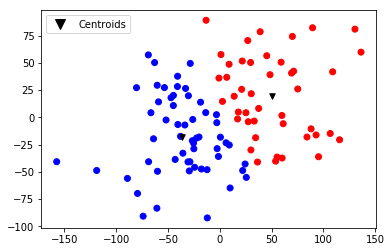

In [4]:
import os
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import metrics

file_path = os.path.join('clustering','data.csv')
data = pd.read_csv(file_path, delimiter=",", header = 0)

#rename column names  from '"x"' to 'x'
old_col_names = list(data.columns)
new_col_names = [name.replace('"',"").strip() for name in old_col_names]
data = data.rename(index=str, columns = dict(zip(old_col_names, new_col_names)))

#fit model
X = data[['x','y']]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
data.ClusterID = kmeans.labels_
print("Inertia: {:.{}f}".format(kmeans.inertia_,2))
print("Silhouette Coefficient: {:.{}f}".format(metrics.silhouette_score(X, kmeans.labels_),2))

# assign different colours to clusters
color_map = {0: 'r',
            1: 'b'}

color_labels = [color_map[cluster_id] for cluster_id in data.ClusterID]

#plot clusters
plt.scatter(data.x, data.y, c=color_labels)

#plot centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', marker = 'v', s=30)
centroid_marker = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                          markersize=10, label='Centroids')
plt.legend(handles=[centroid_marker])

plt.show()

<b>Commentary</b><br>
The data was clustered using a simple k-means clustering method from sklearn. The sklearn KMeans algorithm assigns data points
to clusters based on minial Euclidean distance from cluster centroids.

<b>Disadvantages:</b>
* number of clusters must be known in advance
* sklearn KMeans uses only Euclidean distance
* does not work well for elongated or irregularly shaped clusters

<b>Evaluation:</b>
Since this is an unsupervised task we do not have any actual values to compare the predicted values (cluster IDs) to.
The sklearn implementation uses 'inertia' as a within-cluster coherence metric (within-cluster sum of squares) - the lower, the better.
<br>
A common metric to validate clustering results is silhouette criteria, which is a metric based on within-cluster cohesion and intercluster separation. The values range between -1 and 1, where values close to 1 indicate best result.


# DBSCAN

With DBSCAN we do not have to know the number of clusters in advance, which is in my opinion mostly the case with real-life problems.<br>
DBSCAN takes two parameters: epsilon and min_samples.<br>
Epsilon indicates the maximum distance between two points for them to be considered as neighbours. Min_samples denotes the minimum number of points in the same neighbourhood for a point to be considered part of a cluster.<br>
With DBSCAN not all points are included in clusters: samples which do not have sufficient number of neighbours within the radius of epsilon are marked as noise.

Estimated number of clusters: 2
Silhouette Coefficient: 0.120


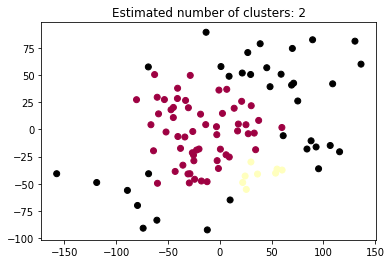

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np

#fit model - I chose eps and min_samples more or less arbitrarily here to get 2 clusters
db = DBSCAN(eps=25, min_samples = 9).fit(X)
labels = db.labels_

#number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

color_map = dict(zip(unique_labels, colors))
color_labels = [color_map[label] if label != -1 else (0,0,0,1) for label in labels]

plt.scatter(X.x, X.y, c=color_labels)
plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

<b>Evaluation</b>
<br>
When tweaking epsilon and min_samples we get different layouts of clusters and with no domain knowledge or further task specification it is hard to decide what works best, whether DBSCAN or k-means or another method.
<br><br>
<b>Advantages</b>
<br>
* number of clusters does not have to be known in advance
* possibility to mark points as noise and exclude them from clusters
* supports other distance metrics besides Euclidean distance

# Regression

<b>Instructions</b>
* Use a regression method of your choice to fit the data in the file.
* Use the Python 3.6 language.
* Consider a general model y = f(x) + error an unknown function f and i.i.d. N(0,sigma) errors.
* Compare the fitted model with a plot of the variable Ey that corresponds to Ey = f(x).
* Comment on the model and the result.

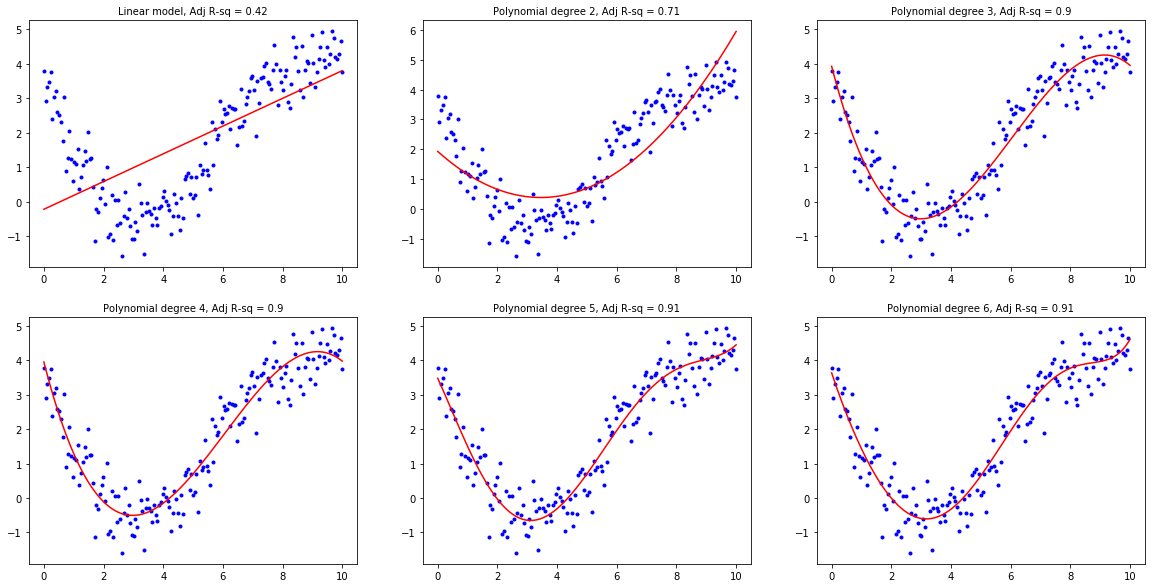

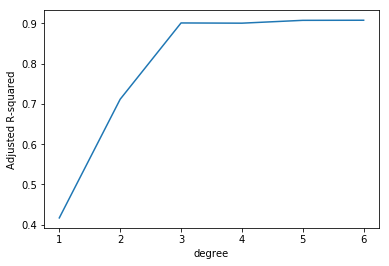

In [8]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

file_path = os.path.join('regression','data.txt')
data = pd.read_csv(file_path, sep = "\t", header=0)

regression = linear_model.LinearRegression()

X = (data.x).values.reshape(-1,1)
y = (data.y).values.reshape(-1,1)

'''
linear regresson
'''
linear_model = regression.fit(X, y)
y_pred_linear = linear_model.predict(X)

#calculate r-squared
r_sq = r2_score(y, y_pred_linear)

#manually calculate adjusted r-squared
#n = number of observations
#k = number of independent variables
k = 1
n = data.shape[0]
r2_adj_linear = 1 - (1 - r_sq) * (n - 1)/(n - (k + 1))

#plot linear model
plt.figure(1, figsize =(20,10))
plt.subplot(231)
title_l = "Linear model, Adj R-sq = {}".format(round(r2_adj_linear,2))
plt.plot(X, y, 'bo', X, y_pred_linear, 'r', markersize=3)
plt.title(title_l, fontsize = 10)

'''
polynomial regression

'''
#start from this subplot number and increment for every plot
subplot_no = 232

#keep a list of adj R2 to plot them later
r_sq_all = [r2_adj_linear]

#fit a model and create a subplot for degree 2 to 6 polynomial
for i in range(2,7):

    poly = PolynomialFeatures(degree = i)
    X_transform = poly.fit_transform(X)

    poly_model = regression.fit(X_transform,y)
    y_pred_poly = poly_model.predict(X_transform)

    #calculate r-squared
    r_sq = r2_score(y, y_pred_poly)

    #calculate adjusted R-squared
    #n = number of observations
    n = data.shape[0]
    #k = number of independent variables (1 of features in X_transform is a constant)
    k = X_transform.shape[1] - 1
    r2_adj = 1-(1-r_sq)*(n - 1)/(n-(k + 1))

    r_sq_all.append(r2_adj)

    title_p = "Polynomial degree {}, Adj R-sq = {}".format(i,round(r2_adj,2))
    plt.subplot(subplot_no)
    plt.plot(X, y, 'bo', X, y_pred_poly, 'r', markersize=3)
    plt.title(title_p, fontsize = 10)
    subplot_no += 1

#plot adjusted R2 against degree of polynomial
plt.figure(2)
plt.plot(range(1,7), r_sq_all)
plt.xlabel('degree')
plt.ylabel('Adjusted R-squared')

plt.show()

<b>Comments</b>
<br>
In order to find a model that minimizes error but does not overfit I evaluated various models according to model fit evaluation criteria adjusted R-squared, which indicates the proportion of variance in the dependent
variable explained by the independent variables but also takes into account model complexity.<br>
As is evident in the adjusted R-squared versus degree of polynomial plot, the Adjusted R-squared grows rapidly until 3rd degree polynomial model
and then the increase slows down.<br>
Therefore, I select <b>3rd degree polynomial</b> as an optimal model also with regard to the model parsimony principal.